In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
sys.path.append("..")

In [6]:
from util import show, plot_images, plot_tensors

In [7]:
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
from skimage.measure import compare_psnr

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

TRAIN_DATA_PATH = "./Confocal_BPAE_B/raw"
GT_DATA_PATH = "./Confocal_BPAE_B/gt"
TRANSFORM_IMG = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()

])
train_data = torchvision.datasets.ImageFolder(
    root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
gt_data = torchvision.datasets.ImageFolder(
    root=GT_DATA_PATH, transform=TRANSFORM_IMG)

dataset1 = train_data
dataset2 = gt_data

In [8]:
class gtmatch():
    def __init__(self, dataset1, dataset2, batch_size):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __getitem__(self, index):
        x = self.dataset1[index][0]
        y = self.dataset2[int(index / batch_size % batch_size)][0]
        return x, y

    def __len__(self):
        return len(self.dataset1)

newdataset = gtmatch(dataset1, dataset2, 50)

In [9]:
batch_size=50
from torch import randn
def add_noise(img):
    return img + randn(img.size())*0.05

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]
        return add_noise(img), img

In [10]:
newdataset = SyntheticNoiseDataset(newdataset, 'train')

In [11]:
from models.RIM import RIM
from models.babyunet import BabyUnet

In [12]:
model = RIM()
model2 = BabyUnet()

In [13]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import logging
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [14]:
from torch.utils.data.sampler import SequentialSampler
validation_split = .2
shuffle_dataset = False
random_seed = 42

# Creating data indices for training and validation splits:
dataset_size = len(newdataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SequentialSampler(train_indices)
valid_sampler = SequentialSampler(val_indices)

train_loader = torch.utils.data.DataLoader(
    newdataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                                sampler=valid_sampler)

## RIM

In [15]:
data_loader = train_loader

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input=[]
best_val_loss = 1


for i, batch in enumerate(data_loader):

    noisy_images, clean_images = batch

    model.train()

    net_input = noisy_images

    if i == 0:
        st = torch.zeros(net_input.size())

    net_output, st = model(net_input, st)

    loss = loss_function(net_output, noisy_images)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    losses.append(loss.item())
    model.eval()

    val_loss = loss_function(net_output, noisy_images)

    val_losses.append(val_loss.item())

    print("Loss (", i, "): \t", round(loss.item(), 4))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = noisy_images*model(noisy_images, st)[0].detach()
        net_input_np=noisy_images.cpu().numpy()[0,0].astype(np.float64)
        denoised_arr = denoised.cpu().numpy()[0, 0].astype(np.float64)
        clean_comp = clean_images.detach().cpu().numpy()[
                             0, 0].astype(np.float64)
        best_psnr = compare_psnr(denoised_arr, clean_comp)
        noisy_input.append(net_input_np)
        best_images.append(denoised_arr)
        clean_image_corr.append(clean_images)
        print("\tModel PSNR: ", np.round(best_psnr, 2))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss ( 0 ): 	 0.0214


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


	Model PSNR:  33.38
Loss ( 1 ): 	 0.0276
Loss ( 2 ): 	 0.0207
	Model PSNR:  38.03
Loss ( 3 ): 	 0.0204
	Model PSNR:  40.23
Loss ( 4 ): 	 0.0195
	Model PSNR:  26.69
Loss ( 5 ): 	 0.0181
	Model PSNR:  35.9
Loss ( 6 ): 	 0.0164
	Model PSNR:  26.93
Loss ( 7 ): 	 0.019
Loss ( 8 ): 	 0.0174
Loss ( 9 ): 	 0.0155
	Model PSNR:  28.99
Loss ( 10 ): 	 0.0211
Loss ( 11 ): 	 0.0154
	Model PSNR:  33.67
Loss ( 12 ): 	 0.0146
	Model PSNR:  38.57
Loss ( 13 ): 	 0.0138
	Model PSNR:  35.87
Loss ( 14 ): 	 0.0137
	Model PSNR:  28.92
Loss ( 15 ): 	 0.0187


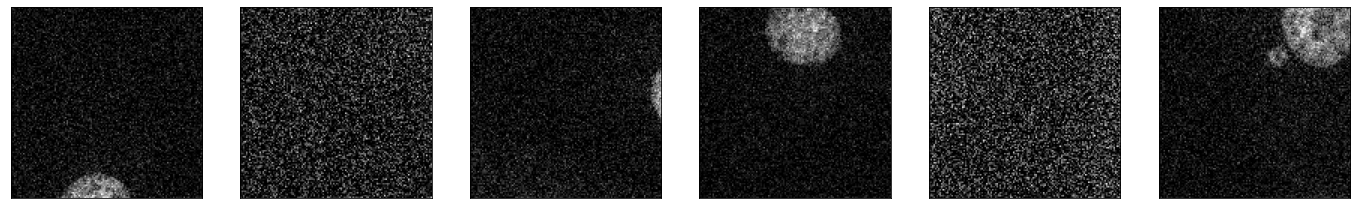

In [22]:
plot_images(np.clip(best_images[::2],0,1))

In [ ]:
mult=[];
for i in range(0,len(best_images[::2])):
    mult.append(noisy_input[::2][i]*best_images[::2][i])
plot_images(mult)

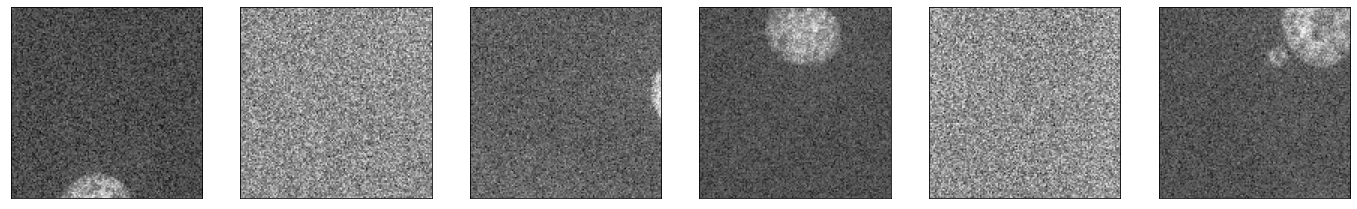

In [17]:
plot_images(noisy_input[::2])

In [ ]:
cleaned=[]
for i, batch in enumerate (validation_loader):
    noisy, clean = test_batch

    model.eval()

    net_input = noisy

    simple_output, st = model(net_input, st)
    
    cleaned.append(noisy_images*simple_output)



In [ ]:
plot_tensors(cleaned[2])

In [ ]:
simple_output = model(noisy, st)[0].detach()

In [ ]:
idx = 1
plot_tensors([clean[idx], noisy[idx], (simple_output*noisy)[idx],(simple_output*noisy)[idx],noisy*simple_output[idx]])

## RIM with J-Invariant Mask

In [ ]:
from mask_RIM import Masker
masker = Masker(width=4, mode='interpolate')

data_loader = train_loader

#noisy, clean = noisy_data_train[0];
#net_input, mask = masker.mask(noisy.unsqueeze(0), 0);

losses = []
val_losses = []
clean_image_corr = []
best_images = []
noisy_input = []
best_val_loss = 1


for i in range(500):
    noisy_images, clean_images = batch

    model.train()

    net_input, mask = masker.mask(noisy, i % (masker.n_masks - 1))

    if i == 0:
        st = torch.zeros(net_input.size())

    net_output, st = model(net_input, st)

    loss = loss_function(net_output*mask, noisy_images*mask)

    optimizer.zero_grad()

    loss.backward.detach()

    optimizer.step()
    
    if i % 10 == 0:


        losses.append(loss.item())


        model.eval()
        val_loss = loss_function(net_output*mask, noisy_images*mask)
        val_losses.append(val_loss.item())

        print("Loss (", i, "): \t", round(loss.item(), 4))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            denoised = model(noisy_images, st)[1].detach()
            denoised_arr = np.clip(denoised.numpy()[0, 0], 0, 1).astype(np.float64)
            clean_comp = np.clip(clean_images.detach().cpu().numpy()[
                                 0, 0], 0, 1).astype(np.float64)
            best_psnr = compare_psnr(denoised_arr, clean_comp)
            noisy_input.append(net_input)
            best_images.append(net_input*denoised)
            clean_image_corr.append(clean_images)
            print("\tModel PSNR: ", np.round(best_psnr, 2))

In [ ]:
print('input')
plot_tensors(noisy_input)
print('denoised')
plot_tensors(best_images)
print('ground truth')
plot_tensors(clean_image_corr)

In [ ]:
i, test_batch = next(enumerate(validation_loader))
noisy, clean = test_batch

In [ ]:
model.eval()
simple_output = model(noisy,st)[1]*noisy
invariant_output = masker.infer_full_image(noisy, model,st)*noisy

In [ ]:
idx = 0
plot_tensors([clean[idx], noisy[idx], simple_output[idx], invariant_output[idx]],
            ["Ground Truth", "Noisy Image", "Single Pass Inference", "J-Invariant Inference"])

In [ ]:
print("Test loss, single pass: ", round(loss_function(clean, simple_output).item(),5))
print("Test loss, J-invariant: ", round(loss_function(clean, invariant_output).item(), 5))

## BABY UNET COMPARISON

In [ ]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

data_loader = train_loader

#noisy, clean = noisy_data_train[0];
#net_input, mask = masker.mask(noisy.unsqueeze(0), 0);

losses = []
val_losses = []
best_images = []
best_val_loss = 1



for i, batch in enumerate(data_loader):

    noisy_images, clean_images = batch
    
    model2.train()
 
    net_input, mask = masker.mask(noisy_images, i)
    #net_input = noisy_images
    
    net_output = model2(net_input)

        
    loss = loss_function(net_output*mask, noisy_images*mask)
    #loss = loss_function(net_output, noisy_images)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()

    losses.append(loss.item())
    model2.eval()
    

    val_loss = loss_function(net_output*mask, noisy_images*mask)
    #val_loss = net_output

    val_losses.append(val_loss.item())



    print("Loss (", i, "): \t", round(loss.item(), 4))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = np.clip(model2(noisy_images).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        clean=np.clip(clean_images.detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        best_psnr = compare_psnr(denoised, clean)
        best_images.append(denoised)
        print("\tModel PSNR: ", np.round(best_psnr, 2))


In [ ]:
plot_images(best_images)

In [ ]:
i, test_batch = next(enumerate(validation_loader))
noisy, clean = test_batch

from mask import Masker

simple_output = model2(noisy)
invariant_output = masker.infer_full_image(noisy, model2)

In [ ]:
idx = 3
plot_tensors([clean[idx], noisy[idx], simple_output[idx], invariant_output[idx]],
            ["Ground Truth", "Noisy Image", "Single Pass Inference", "J-Invariant Inference"])

In [ ]:
print("Test loss, single pass: ", round(loss_function(clean, simple_output[0]).item(), 3))
print("Test loss, J-invariant: ", round(loss_function(clean, invariant_output).item(), 3))

In [ ]:
plot_tensors(invariant_output[idx]-noisy[idx])

In [ ]:
plot_tensors(noisy)